In [4]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [5]:
from pydantic import BaseModel
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage,SystemMessage
from langgraph.graph.message import add_messages
from typing import List, Annotated
from typing_extensions import TypedDict
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Markdown, Image
from pprint import pprint

In [8]:
from langchain_community.tools import WikipediaQueryRun,ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper
from langchain_tavily import TavilySearch

**Tavily**

In [9]:
tavily = TavilySearch(max_results=5,topic="general")

In [10]:
tavily.invoke("Latest new in India")

{'query': 'Latest new in India',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://indianexpress.com/',
   'title': 'Latest News Today: Breaking News and Top Headlines from India ...',
   'content': 'Latest News · 145 MPs across party lines submit motion in Parliament to impeach Justice Yashwant Varma · Delhi meat shops shut during Sawan despite no official',
   'score': 0.6301622,
   'raw_content': None},
  {'url': 'https://www.ndtv.com/',
   'title': "NDTV.com: Get Latest News, India News, Breaking News, Today's ...",
   'content': "NDTV.com provides latest news from India and around the world. Get breaking news alerts from India and follow today's live news updates in field of politics",
   'score': 0.5450684,
   'raw_content': None},
  {'url': 'https://www.cnn.com/world/india',
   'title': 'India news - breaking news, video and headlines and opinion - CNN',
   'content': "Latest news · 'Aspirations of 1.4 billion': India celebrates as first

**Wikipedia**

In [13]:
wiki_api = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=1000)
wiki = WikipediaQueryRun(api_wrapper=wiki_api)

In [14]:
wiki.invoke("Python programming language")

'Page: Python (programming language)\nSummary: Python is a high-level, general-purpose programming language. Its design philosophy emphasizes code readability with the use of significant indentation.\nPython is dynamically type-checked and garbage-collected. It supports multiple programming paradigms, including structured (particularly procedural), object-oriented and functional programming.\nGuido van Rossum began working on Python in the late 1980s as a successor to the ABC programming language, and he first released it in 1991 as Python 0.9.0. Python 2.0 was released in 2000. Python 3.0, released in 2008, was a major revision not completely backward-compatible with earlier versions. Python 2.7.18, released in 2020, was the last release of Python 2.\nPython consistently ranks as one of the most popular programming languages, and it has gained widespread use in the machine learning community.\n\n'

**Arxiv**

In [16]:
arxiv_api = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=1000)
arxiv = ArxivQueryRun(api_wrapper=arxiv_api)

In [17]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter layers reduces performances\nfor more layers skipped, except for skipping the attention layers.\n\n

In [18]:
tools = [tavily, wiki, arxiv]

In [19]:
llm = ChatOpenAI(model="gpt-4o-mini",max_tokens=1000)
llm.invoke("What is the capital of India?")

AIMessage(content='The capital of India is New Delhi.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 14, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'id': 'chatcmpl-BvoAIaXBwp4VDnn6ZvdjbRVZVAsSk', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--0bcf3608-ad35-4fc6-b1eb-505a6572387c-0', usage_metadata={'input_tokens': 14, 'output_tokens': 8, 'total_tokens': 22, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [20]:
llm_tool = llm.bind_tools(tools)

In [21]:
class MyState(TypedDict):
    messages: Annotated[List[AnyMessage],add_messages]

In [22]:
def llm_tool_node(state: MyState):
    response = llm_tool.invoke(state["messages"])
    return {"messages": [response]}

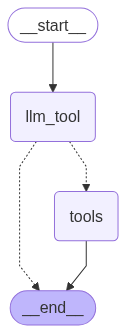

In [23]:
builder = StateGraph(MyState)

#node
builder.add_node("llm_tool", llm_tool_node)
builder.add_node("tools",ToolNode(tools))


#edges
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    tools_condition
)
builder.add_edge("tools", END)


graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
response = graph.invoke(
    {"messages":HumanMessage(content="What is the capital of India?")}
)

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the capital of India?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_TDBAdSTeSoFyhDAXAZNeLpHE)
 Call ID: call_TDBAdSTeSoFyhDAXAZNeLpHE
  Args:
    query: capital of India
================================= Tool Message =================================
Name: wikipedia

Page: List of capitals of India
Summary: This is a list of locations which have served as capital cities in India. The current capital city is New Delhi, which replaced Calcutta in 1911.




In [28]:
response = graph.invoke(
    {"messages":HumanMessage(content="Tom Cruise")}
)

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Tom Cruise
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_VnLx5uy75voo7sGAIi9ZwEzZ)
 Call ID: call_VnLx5uy75voo7sGAIi9ZwEzZ
  Args:
    query: Tom Cruise
================================= Tool Message =================================
Name: wikipedia

Page: Tom Cruise
Summary: Thomas Cruise Mapother IV (born July 3, 1962) is an American actor and film producer. Regarded as a Hollywood icon, he has received various accolades, including an Honorary Palme d'Or and three Golden Globe Awards, in addition to nominations for four Academy Awards. As of 2025, his films have grossed over $13.3 billion worldwide, placing him among the highest-grossing actors of all time. One of Hollywood's most bankable stars, he is consistently one of the world's highest-paid actors.
Cruise began acting in the early 1980s and made his breakthrough with leading roles in

In [29]:
response = graph.invoke(
    {"messages":HumanMessage(content="Attention is all you need")}
)

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Attention is all you need
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_TPOvtBW5zJyDZfA10Hhpfsky)
 Call ID: call_TPOvtBW5zJyDZfA10Hhpfsky
  Args:
    query: Attention is all you need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time on the performance of
Llama-v2 models. We find that dropping dreeper attention la

In [30]:
response = graph.invoke(
    {"messages":HumanMessage(content="Latest news in India")}
)

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Latest news in India
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_qYBwNpvxeK63fGaxi6cFx1CH)
 Call ID: call_qYBwNpvxeK63fGaxi6cFx1CH
  Args:
    query: latest news India
    topic: news
    time_range: week
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "latest news India", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.aljazeera.com/where/india/", "title": "India | Today's latest from Al Jazeera", "content": "![The tail of an Air India Boeing 787 Dreamliner is seen stuck on a building after a crash in Ahmedabad, India, on June 12, 2025 [Amit Dave/Reuters]](/wp-content/uploads/2025/06/2025-06-12T122137Z_1811025978_RC2Z0FA0JBC9_RTRMADP_3_INDIA-CRASH-1749731990.jpg?resize=270%2C180&quality=80)\n\n### Doom